In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('realty.csv', index_col=['date'])
prices.head(10)

DLF.NS  GODREJPROP.NS  OBEROIRLTY.NS  PHOENIXLTD.NS  \
date                                                                  
01-01-2018  256.700012     703.849976     480.200012     633.650024   
02-01-2018  253.899994     703.650024     480.399994     635.200012   
03-01-2018  258.299988     710.750000     479.600006     618.250000   
04-01-2018  257.500000     714.750000     487.450012     580.599976   
05-01-2018  259.950012     725.250000     489.700012     575.099976   
08-01-2018  260.250000     736.950012     493.450012     585.650024   
09-01-2018  269.850006     791.549988     506.700012     602.549988   
10-01-2018  269.350006     826.349976     528.000000     589.500000   
11-01-2018  270.500000     844.599976     555.250000     606.650024   
12-01-2018  268.549988     834.750000     532.700012     595.250000   

            PRESTIGE.NS  BRIGADE.NS  IBREALEST.NS    SOBHA.NS  SUNTECK.NS  
date                                                                       
01-01-2018   315.649994  208.933334    219.199997  606.700012  418.549988  
02-01-2018   321.500000  204.899994    215.500000  589.549988  418.649994  
03-01-2018   321.000000  205.300003    216.000000  603.250000  414.450012  
04-01-2018   338.600006  205.100006    219.250000  610.000000  415.600006  
05-01-2018   335.049988  205.500000    221.250000  605.549988  413.149994  
08-01-2018   332.399994  209.000000    229.250000  599.799988  413.399994  
09-01-2018   333.750000  208.533341    235.850006  606.000000  409.750000  
10-01-2018   334.049988  208.100006    247.100006  604.400024  409.899994  
11-01-2018   345.000000  210.199997    255.649994  605.349976  406.549988  
12-01-2018   337.950012  210.266663    253.600006  592.400024  404.700012

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

DLF.NS  GODREJPROP.NS  OBEROIRLTY.NS  PHOENIXLTD.NS  \
date                                                                  
01-01-2018  256.700012     703.849976     480.200012     633.650024   
02-01-2018  253.899994     703.650024     480.399994     635.200012   
30-12-2020  235.949997    1393.750000     567.950012     763.049988   
31-12-2020  232.850006    1432.150024     583.400024     774.549988   

            PRESTIGE.NS  BRIGADE.NS  IBREALEST.NS    SOBHA.NS  SUNTECK.NS  
date                                                                       
01-01-2018   315.649994  208.933334    219.199997  606.700012  418.549988  
02-01-2018   321.500000  204.899994    215.500000  589.549988  418.649994  
30-12-2020   264.899994  246.100006     79.300003  382.500000  356.049988  
31-12-2020   266.100006  249.100006     82.199997  414.649994  347.950012

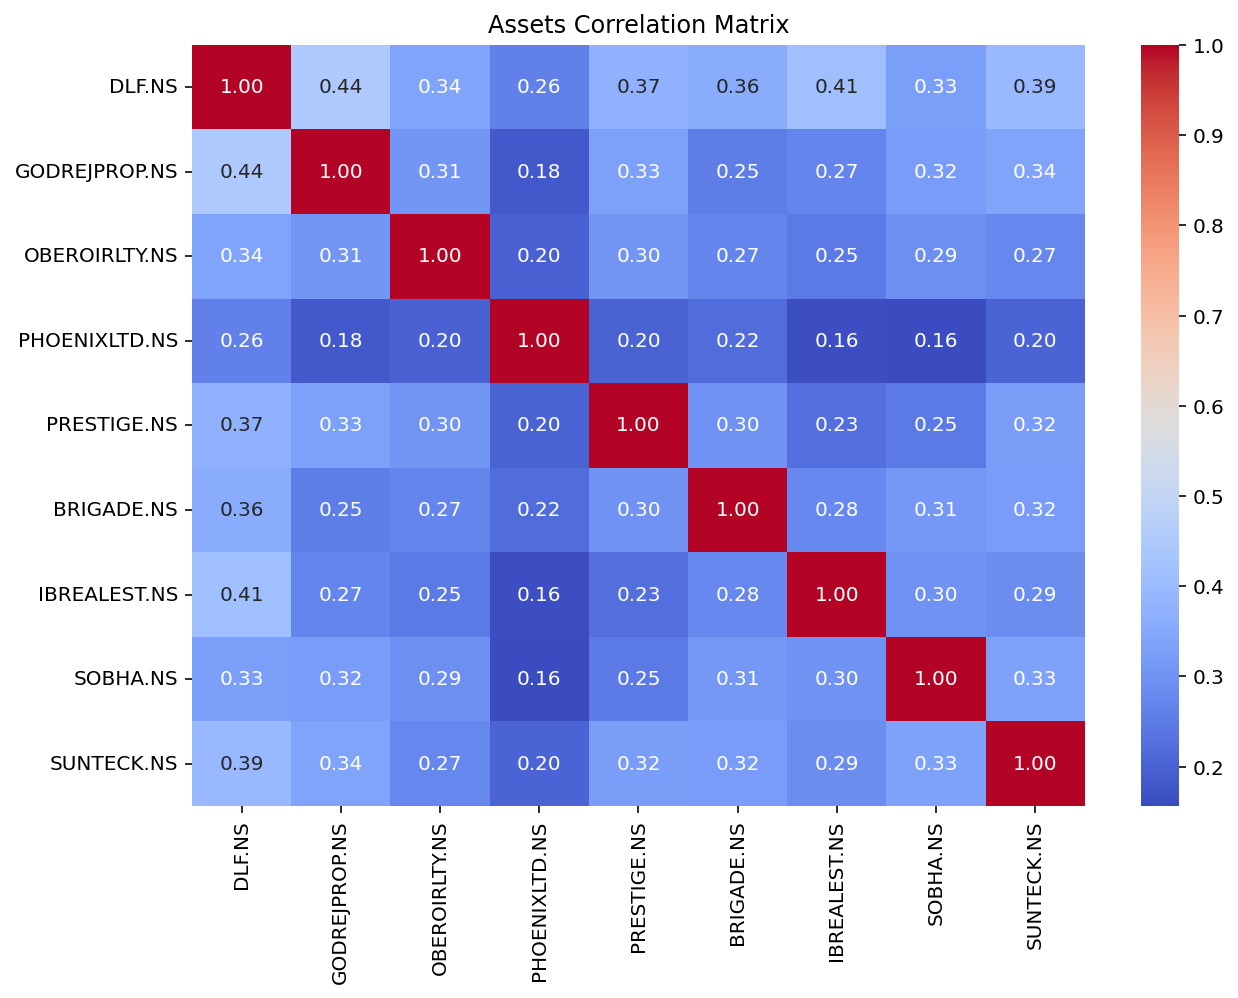

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('DLF.NS', 'OBEROIRLTY.NS'), ('OBEROIRLTY.NS', 'PRESTIGE.NS'), ('OBEROIRLTY.NS', 'SOBHA.NS'), ('OBEROIRLTY.NS', 'SUNTECK.NS'), ('PHOENIXLTD.NS', 'PRESTIGE.NS'), ('PHOENIXLTD.NS', 'BRIGADE.NS')]


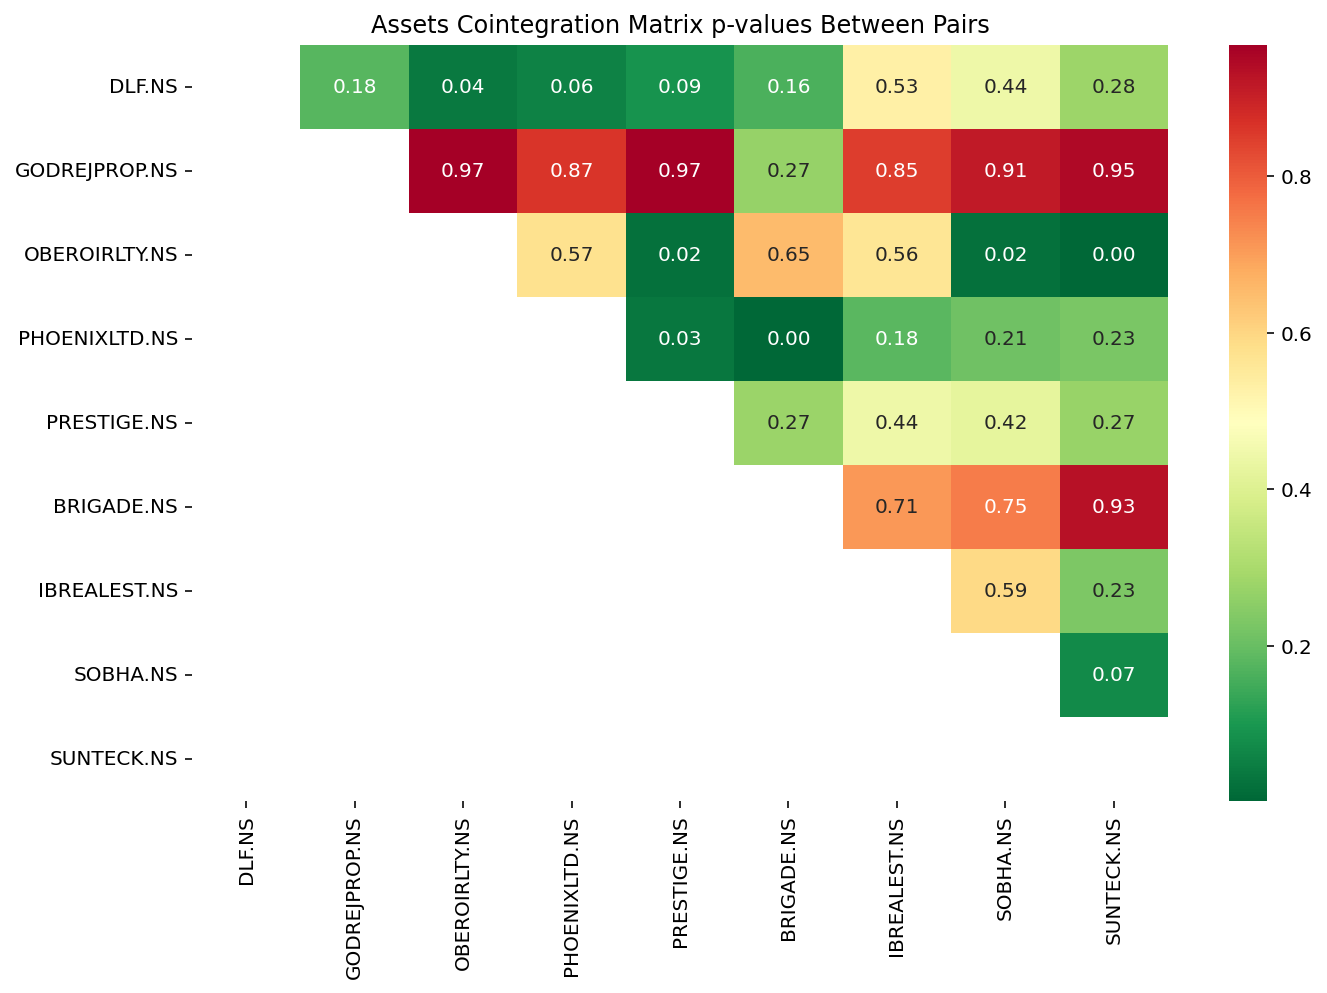

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'PHOENIXLTD.NS'
asset2 = 'BRIGADE.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

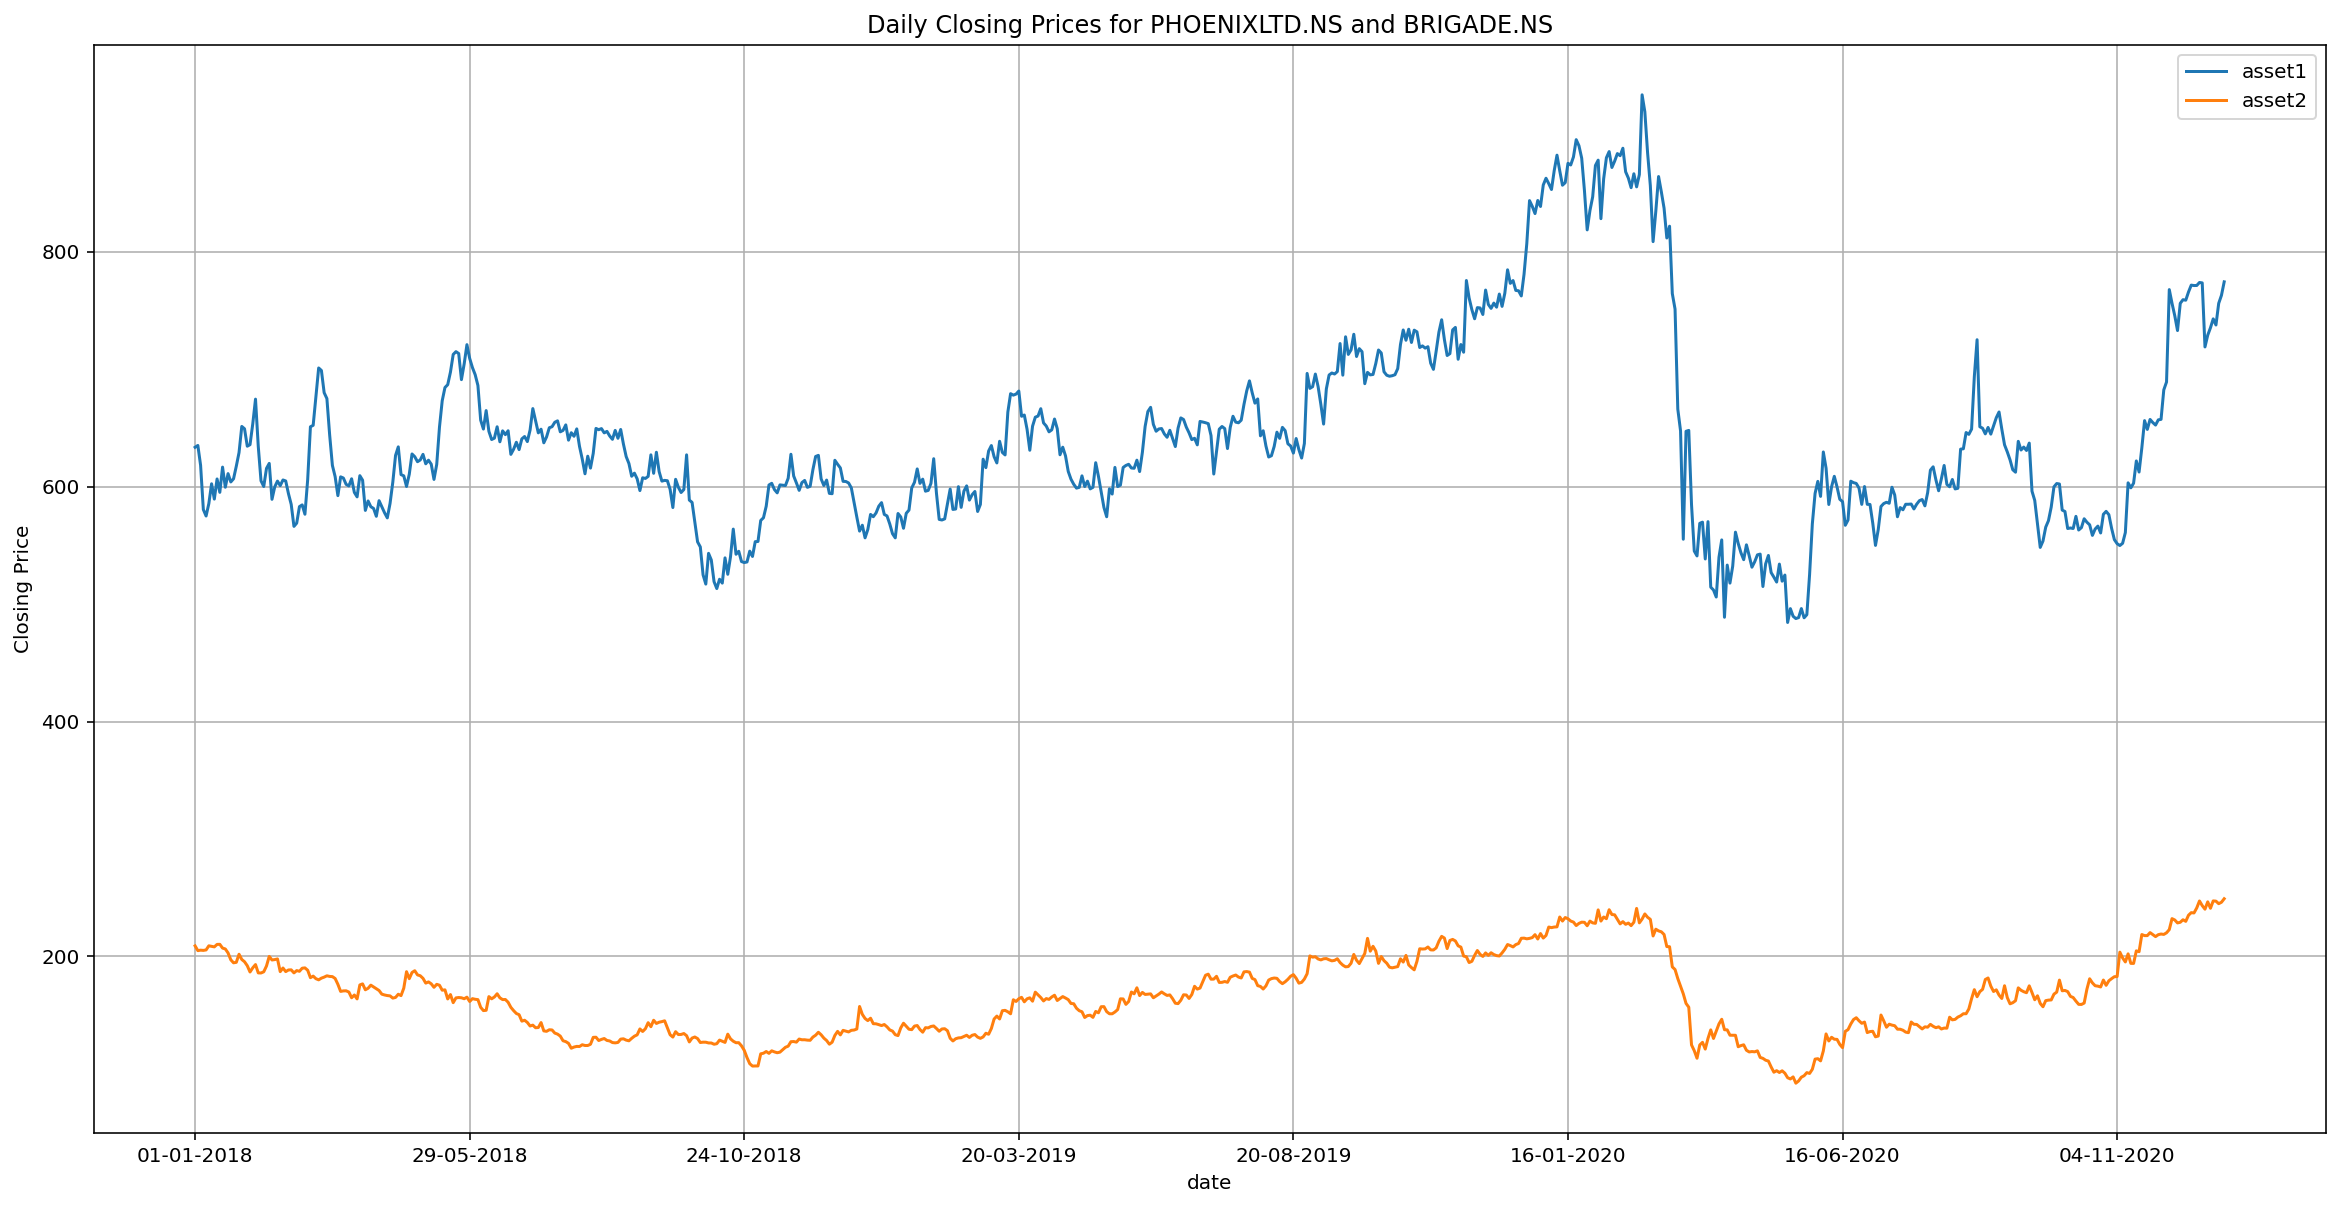

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.982
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                          4.090e+04
Date:                Sun, 20 Mar 2022   Prob (F-statistic):                        0.00
Time:                        23:58:17   Log-Likelihood:                         -3361.7
No. Observations:                 740   AIC:                                      6725.
Df Residuals:                     739   BIC:                                      6730.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.2607      0.001    202.232      0.000       0.258       0.263
==============================================================================
Omnibus:                       18.226   Durbin-Watson:                   0.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.891
Skew:                           0.320   Prob(JB):                     0.000215
Kurtosis:                       2.629   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

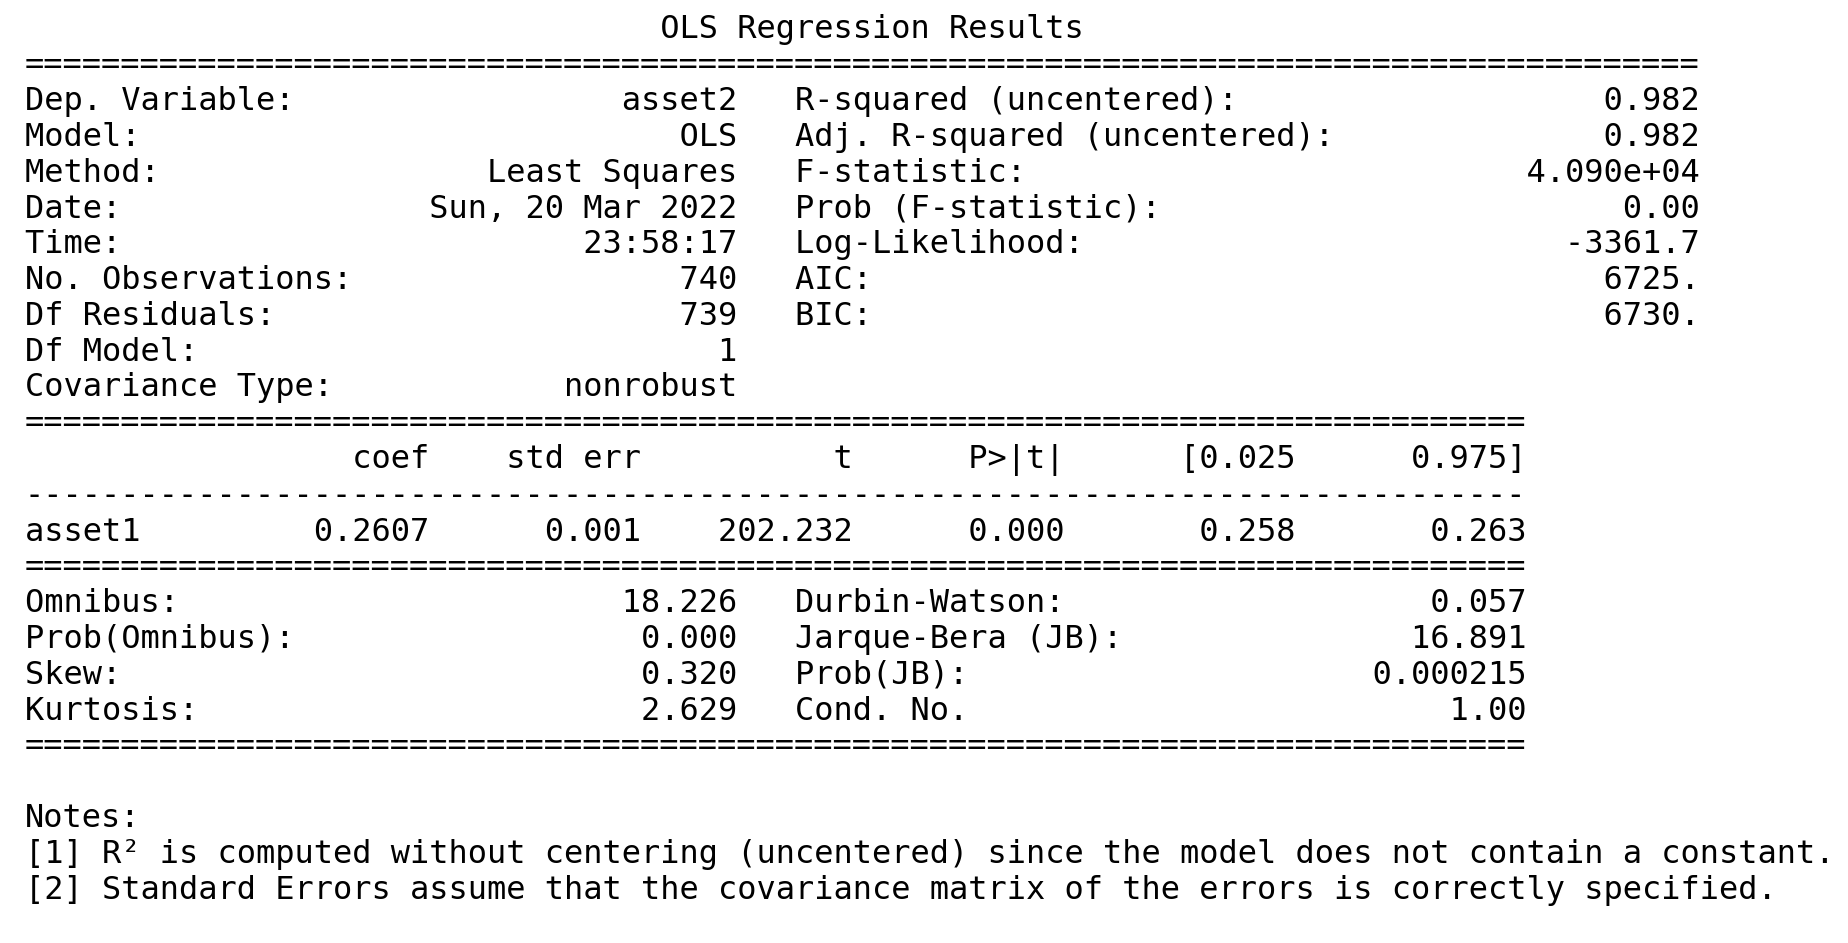

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.2607021287089955


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

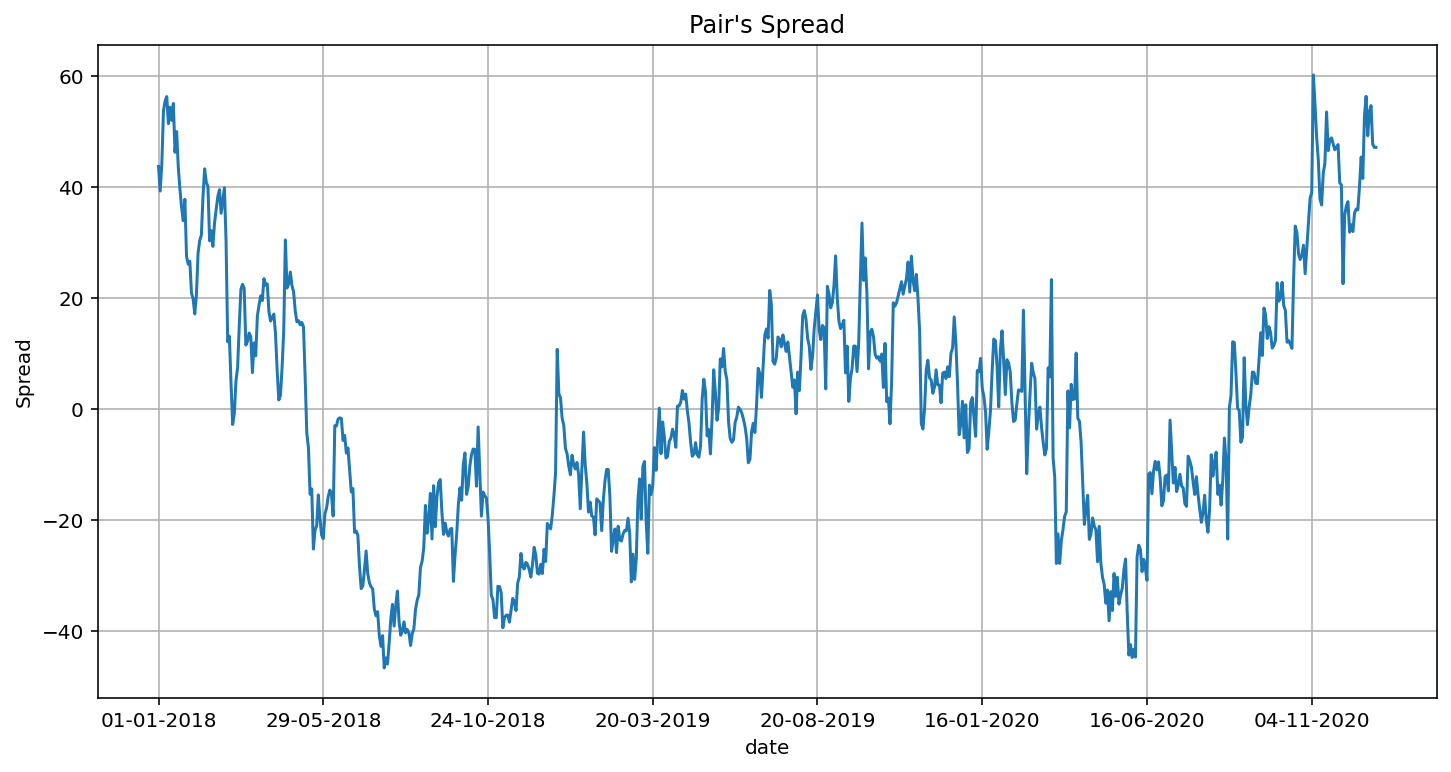

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-2.8607250692824744,
 0.05010947143089552,
 1,
 738,
 {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903},
 4584.257650085975)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -2.8607250692824744


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.4392418578608983, '5%': -2.86546426916434, '10%': -2.568859710342903}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                              
01-01-2021  785.450012  249.399994
04-01-2021  773.599976  252.699997
05-01-2021  763.849976  257.100006
06-01-2021  767.349976  251.449997
07-01-2021  753.099976  258.200012

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  785.450012  249.399994  1.416375            1.0           -1.0
04-01-2021  773.599976  252.699997  1.180243            1.0           -1.0
05-01-2021  763.849976  257.100006  0.937959            1.0           -1.0
06-01-2021  767.349976  251.449997  1.154389            1.0           -1.0
07-01-2021  753.099976  258.200012  0.792312            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

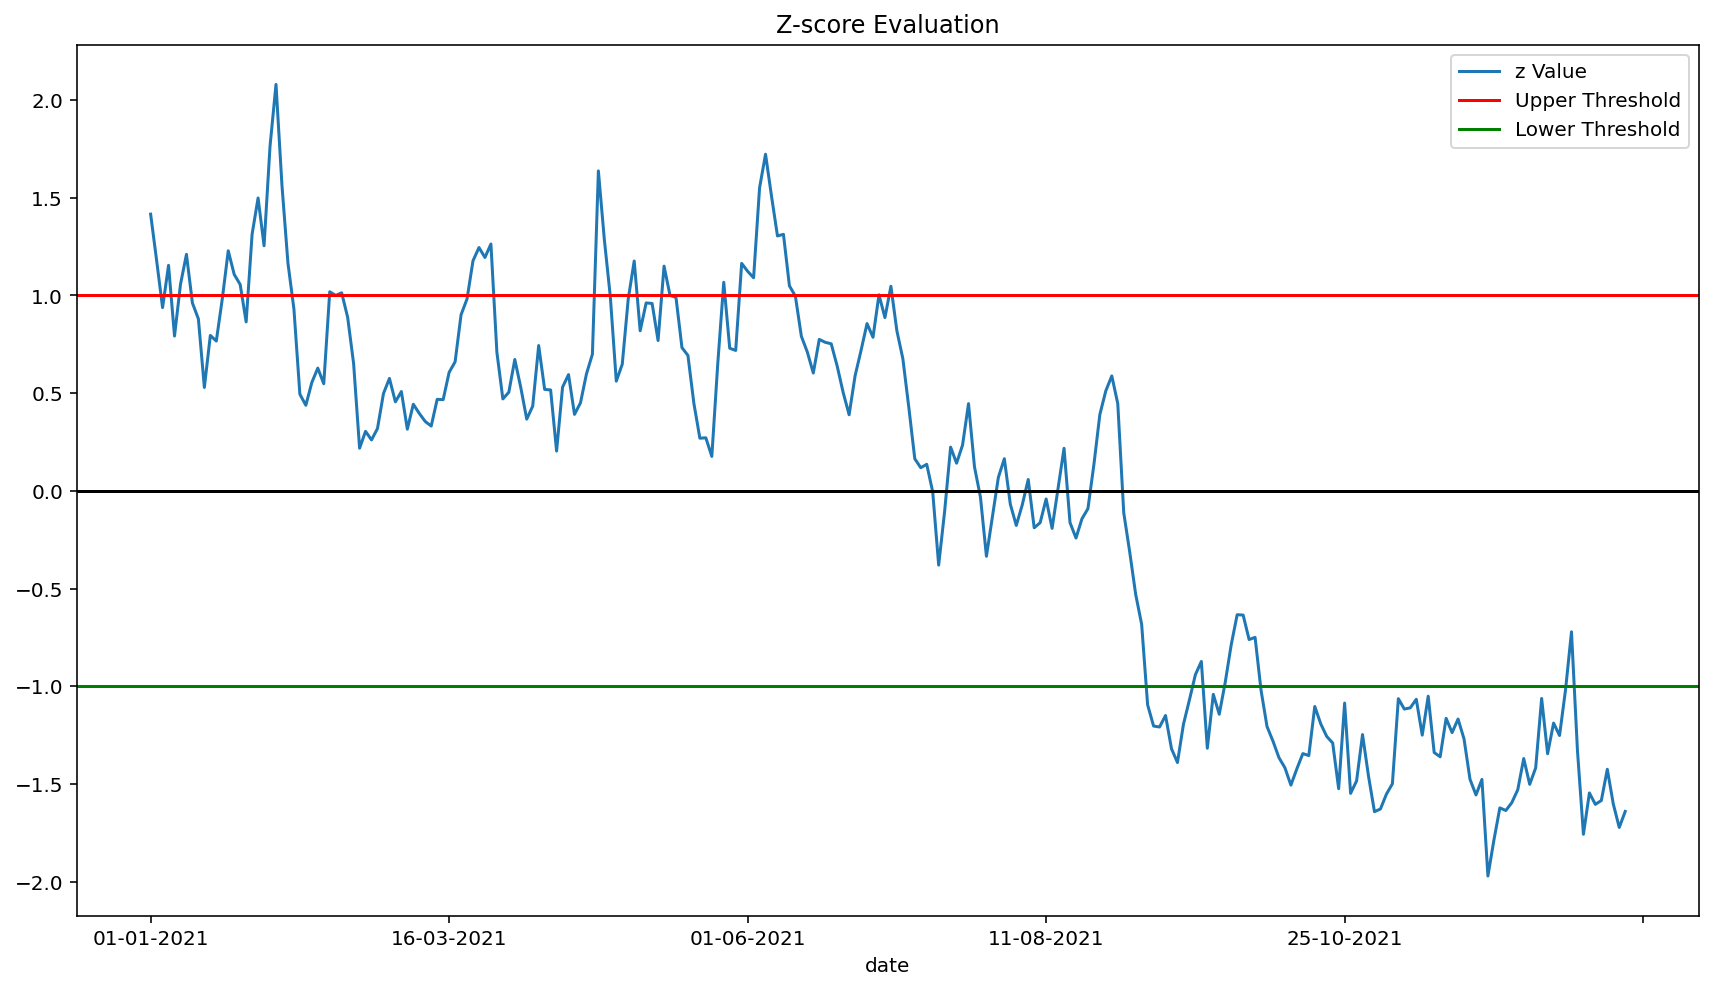

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  785.450012  249.399994  1.416375            1.0           -1.0   
04-01-2021  773.599976  252.699997  1.180243            1.0           -1.0   
05-01-2021  763.849976  257.100006  0.937959            1.0           -1.0   
29-12-2021  991.950012  490.100006 -1.602657            1.0           -1.0   
30-12-2021  987.400024  498.899994 -1.722896            1.0           -1.0   
31-12-2021  985.349976  490.299988 -1.640984            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021         0         1.0         0        -1.0  
29-12-2021         1         0.0        -1         0.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  785.450012  249.399994  1.416375            1.0           -1.0   
04-01-2021  773.599976  252.699997  1.180243            1.0           -1.0   
06-01-2021  767.349976  251.449997  1.154389            1.0           -1.0   
08-01-2021  790.599976  262.200012  1.056620            1.0           -1.0   
11-01-2021  822.549988  267.700012  1.210606            1.0           -1.0   
20-01-2021  780.349976  253.399994  1.229017            1.0           -1.0   
21-01-2021  764.500000  251.949997  1.107797            1.0           -1.0   
22-01-2021  736.599976  244.300003  1.056325            1.0           -1.0   
27-01-2021  733.500000  235.750000  1.314401            1.0           -1.0   
28-01-2021  721.599976  226.899994  1.499261            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
06-01-2021        -1        -1.0         1         1.0  
08-01-2021        -1        -1.0         1         1.0  
11-01-2021        -1         0.0         1         0.0  
20-01-2021        -1        -1.0         1         1.0  
21-01-2021        -1         0.0         1         0.0  
22-01-2021        -1         0.0         1         0.0  
27-01-2021        -1        -1.0         1         1.0  
28-01-2021        -1         0.0         1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   785.450012  249.399994  1.416375            1.0           -1.0   
05-01-2021   763.849976  257.100006  0.937959            1.0           -1.0   
06-01-2021   767.349976  251.449997  1.154389            1.0           -1.0   
07-01-2021   753.099976  258.200012  0.792312            1.0           -1.0   
08-01-2021   790.599976  262.200012  1.056620            1.0           -1.0   
21-09-2021   854.650024  401.200012 -1.317598            1.0           -1.0   
24-09-2021   945.500000  419.100006 -0.980144            1.0           -1.0   
04-10-2021   956.950012  427.049988 -1.020884            1.0           -1.0   
20-12-2021  1011.799988  430.100006 -0.721397            1.0           -1.0   
21-12-2021   958.200012  450.750000 -1.329519            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
05-01-2021         0         1.0         0        -1.0  
06-01-2021        -1        -1.0         1         1.0  
07-01-2021         0         1.0         0        -1.0  
08-01-2021        -1        -1.0         1         1.0  
21-09-2021         1         1.0        -1        -1.0  
24-09-2021         0        -1.0         0         1.0  
04-10-2021         1         1.0        -1        -1.0  
20-12-2021         0        -1.0         0         1.0  
21-12-2021         1         1.0        -1        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

763.849976    1
753.099976    1
956.950012    1
854.650024    1
871.299988    1
837.950012    1
826.849976    1
836.049988    1
769.099976    1
729.349976    1
747.950012    1
740.950012    1
779.599976    1
832.650024    1
802.849976    1
729.750000    1
819.299988    1
958.200012    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                          
01-01-2021   785.450012  249.399994  1.416375            1.0           -1.0   
04-01-2021   773.599976  252.699997  1.180243            1.0           -1.0   
05-01-2021   763.849976  257.100006  0.937959            1.0           -1.0   
06-01-2021   767.349976  251.449997  1.154389            1.0           -1.0   
07-01-2021   753.099976  258.200012  0.792312            1.0           -1.0   
...                 ...         ...       ...            ...            ...   
27-12-2021   995.900024  490.450012 -1.584926            1.0           -1.0   
28-12-2021  1028.449951  492.049988 -1.425176            1.0           -1.0   
29-12-2021   991.950012  490.100006 -1.602657            1.0           -1.0   
30-12-2021   987.400024  498.899994 -1.722896            1.0           -1.0   
31-12-2021   985.349976  490.299988 -1.640984            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021         0         1.0         0        -1.0  
06-01-2021        -1        -1.0         1         1.0  
07-01-2021         0         1.0         0        -1.0  
...              ...         ...       ...         ...  
27-12-2021         1         0.0        -1         0.0  
28-12-2021         1         0.0        -1         0.0  
29-12-2021         1         0.0        -1         0.0  
30-12-2021         1         0.0        -1         0.0  
31-12-2021         1         0.0        -1         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

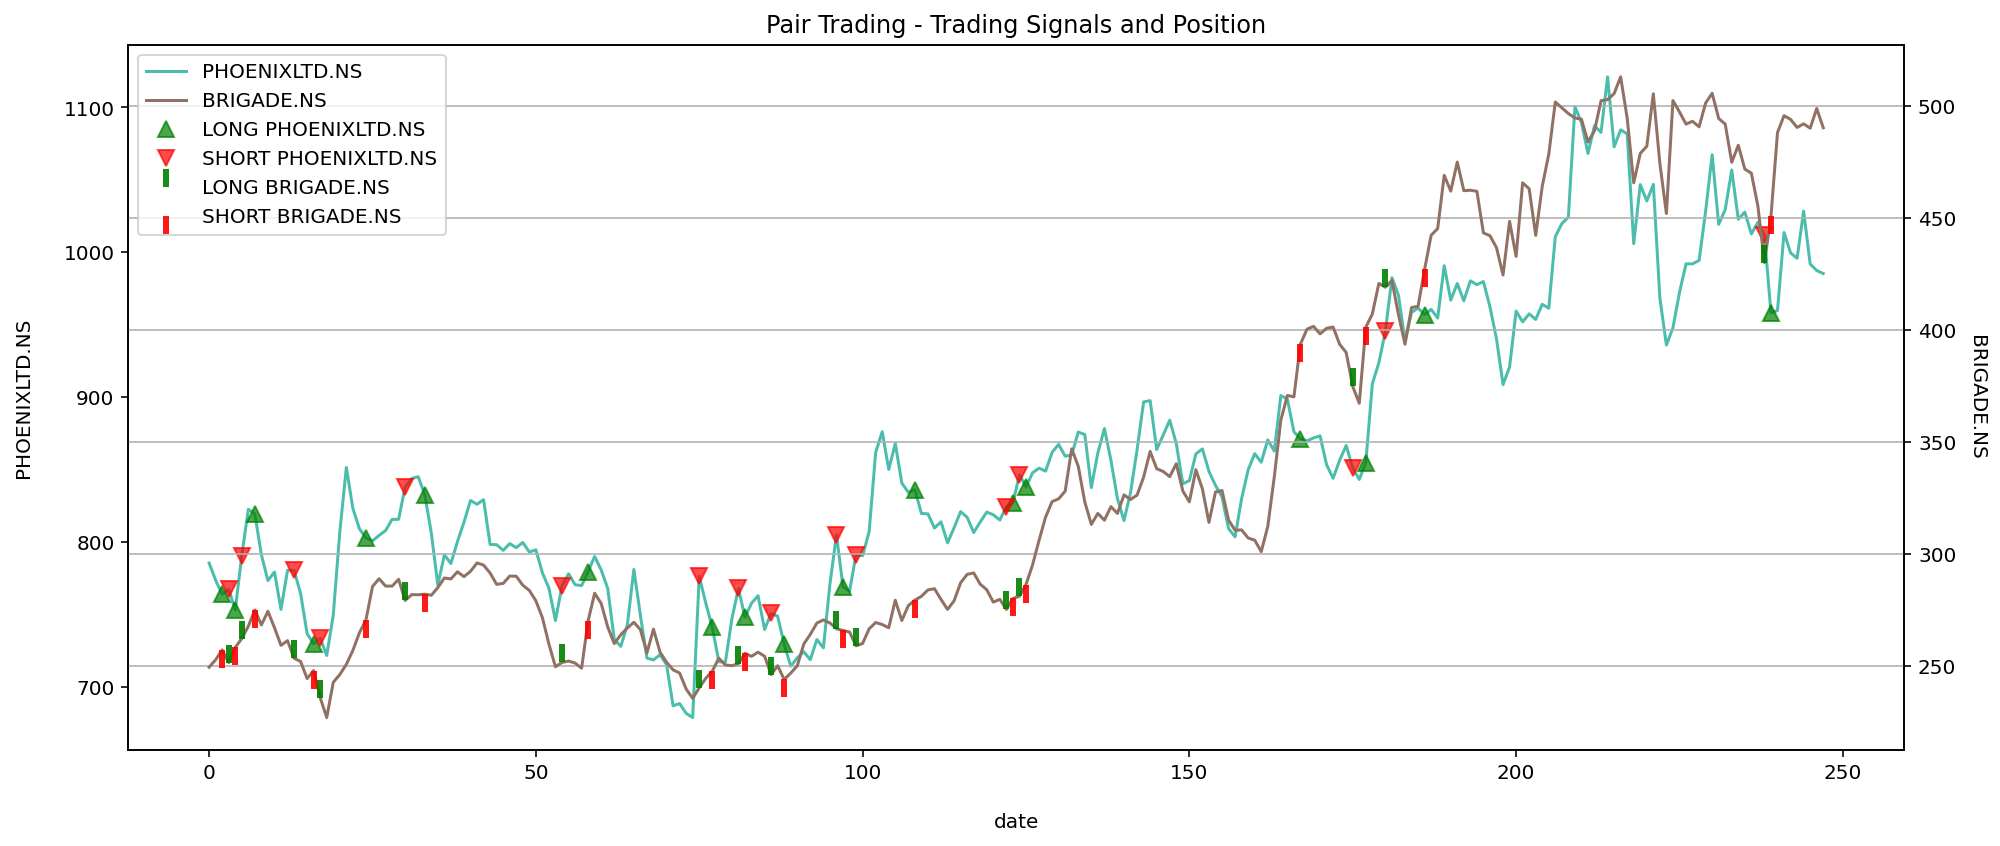

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0     785.450012            NaN            NaN            NaN       NaN   
1     773.599976       0.000000  100000.000000  100000.000000       NaN   
2     763.849976   67982.647828   32017.352172  100000.000000  0.000000   
3     767.349976       0.000000  100311.500000  100311.500000  0.003115   
4     753.099976   67025.897828   33285.602172  100311.500000  0.000000   
243   995.900024  177270.204343  -38915.642382  138354.561962 -0.004674   
244  1028.449951  183064.091278  -38915.642382  144148.448896  0.041877   
245   991.950012  176567.102172  -38915.642382  137651.459790 -0.045072   
246   987.400024  175757.204343  -38915.642382  136841.561962 -0.005884   
247   985.349976  175392.295657  -38915.642382  136476.653275 -0.002667   

     positions1  
0           NaN  
1           0.0  
2           1.0  
3          -1.0  
4           1.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1  total asset1   return1  positions1
0  785.450012           NaN            NaN           NaN       NaN         NaN
2  763.849976  67982.647828   32017.352172      100000.0  0.000000         1.0
3  767.349976      0.000000  100311.500000      100311.5  0.003115        -1.0
4  753.099976  67025.897828   33285.602172      100311.5  0.000000         1.0
5  790.599976      0.000000  103649.000000      103649.0  0.033271        -1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0     785.450012            NaN            NaN            NaN       NaN   
1     773.599976       0.000000  100000.000000  100000.000000       NaN   
2     763.849976   67982.647828   32017.352172  100000.000000  0.000000   
3     767.349976       0.000000  100311.500000  100311.500000  0.003115   
4     753.099976   67025.897828   33285.602172  100311.500000  0.000000   
243   995.900024  177270.204343  -38915.642382  138354.561962 -0.004674   
244  1028.449951  183064.091278  -38915.642382  144148.448896  0.041877   
245   991.950012  176567.102172  -38915.642382  137651.459790 -0.045072   
246   987.400024  175757.204343  -38915.642382  136841.561962 -0.005884   
247   985.349976  175392.295657  -38915.642382  136476.653275 -0.002667   

     positions1      asset2      holdings2          cash2   total asset2  \
0           NaN  249.399994            NaN            NaN            NaN   
1           0.0  252.699997       0.000000  100000.000000  100000.000000   
2           1.0  257.100006  -49877.401183  149877.401183  100000.000000   
3          -1.0  251.449997       0.000000  101096.101785  101096.101785   
4           1.0  258.200012  -50090.802367  151186.904152  101096.101785   
243         0.0  490.450012 -190294.604734  258216.697672   67922.092938   
244         0.0  492.049988 -190915.395266  258216.697672   67301.302406   
245         0.0  490.100006 -190158.802367  258216.697672   68057.895305   
246         0.0  498.899994 -193573.197633  258216.697672   64643.500039   
247         0.0  490.299988 -190236.395266  258216.697672   67980.302406   

          return2  positions2  
0             NaN         NaN  
1             NaN         0.0  
2    2.220446e-16        -1.0  
3    1.096102e-02         1.0  
4    0.000000e+00        -1.0  
243  2.099638e-02         0.0  
244 -9.139744e-03         0.0  
245  1.124188e-02         0.0  
246 -5.016898e-02         0.0  
247  5.161853e-02         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1  total asset1   return1  \
0  785.450012           NaN            NaN           NaN       NaN   
2  763.849976  67982.647828   32017.352172      100000.0  0.000000   
3  767.349976      0.000000  100311.500000      100311.5  0.003115   
4  753.099976  67025.897828   33285.602172      100311.5  0.000000   
5  790.599976      0.000000  103649.000000      103649.0  0.033271   

   positions1      asset2     holdings2          cash2   total asset2  \
0         NaN  249.399994           NaN            NaN            NaN   
2         1.0  257.100006 -49877.401183  149877.401183  100000.000000   
3        -1.0  251.449997      0.000000  101096.101785  101096.101785   
4         1.0  258.200012 -50090.802367  151186.904152  101096.101785   
5        -1.0  262.200012      0.000000  100320.101785  100320.101785   

        return2  positions2  
0           NaN         NaN  
2  2.220446e-16        -1.0  
3  1.096102e-02         1.0  
4  0.000000e+00        -1.0  
5 -7.675865e-03         1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

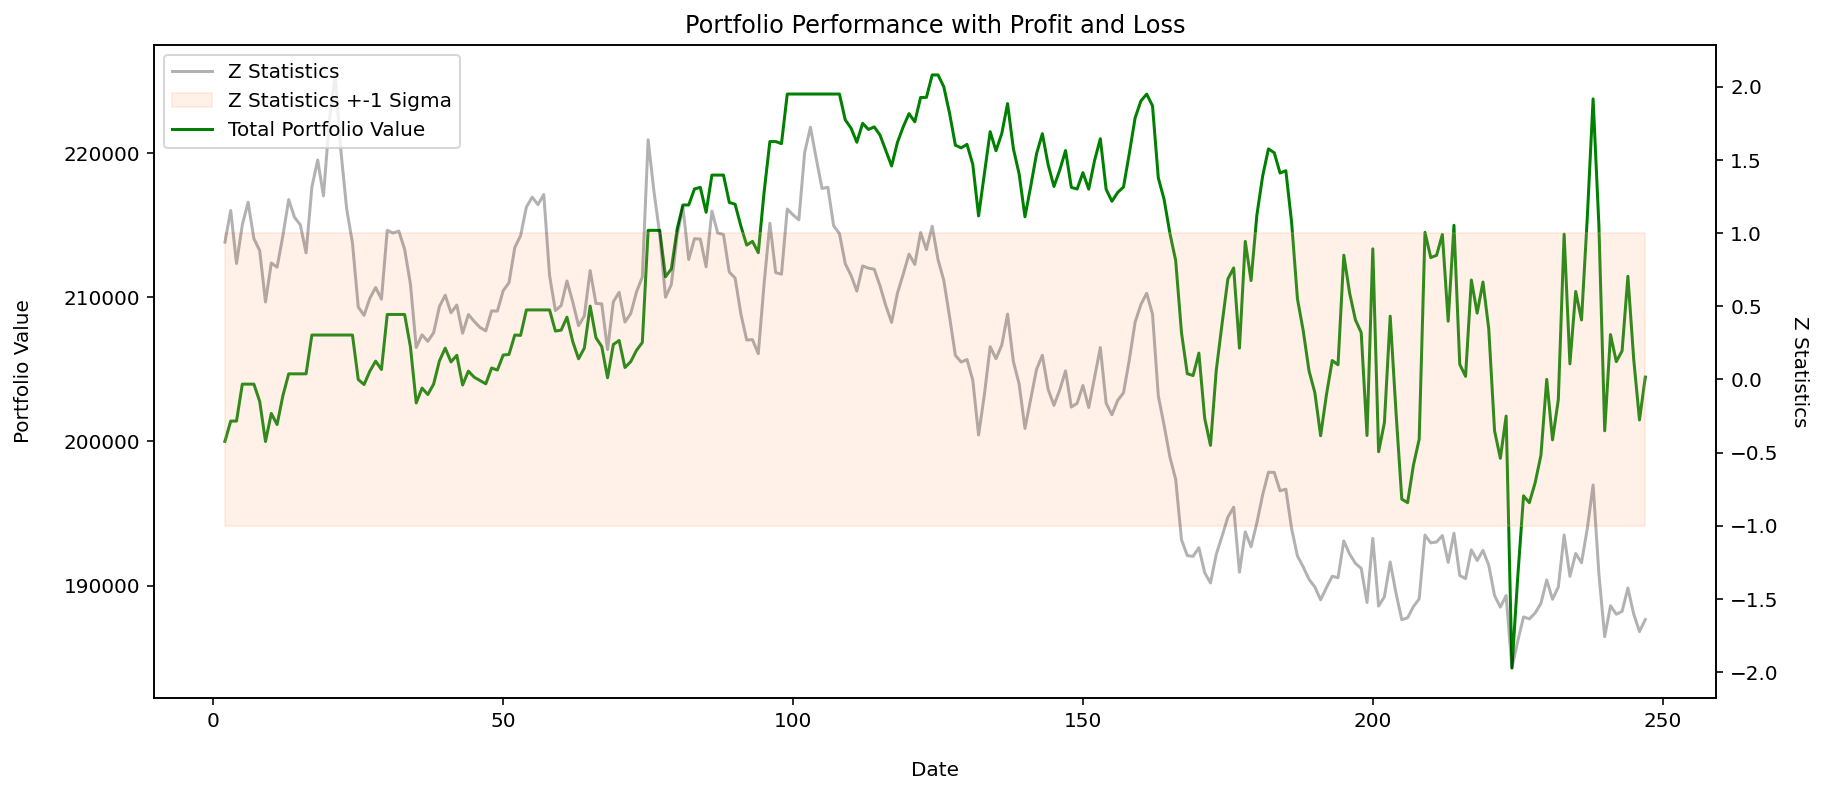

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [46]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

204456.95568079996

In [47]:
profit = final_portfolio - 2*initial_capital
profit

4456.955680799962

In [48]:
roi = (profit/(2*initial_capital))*100
roi

2.2284778403999805

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 190.224%
